 # Gitcoin Metabase EDA


In [1]:
# Magic for getting the execution time for each cell
(get_ipython().run_line_magic("load_ext", "autotime"))

import plotly.express as px
# Power laws are probability distributions with the form:p(x)∝x−α
import powerlaw
import matplotlib.pyplot as plt
import networkx as nx
import json
import pandas as pd
import numpy as np
import seaborn as sns

pd.options.plotting.backend = "plotly"

 ## Dataframe wrangling


In [2]:
DATA_PATH = "../data/query_result_2020-10-12T20_42_24.031Z.csv"
raw_df = pd.read_csv(DATA_PATH)

time: 305 ms


In [3]:
# Parse the normalized data strings into dictionaries
json_data = raw_df.normalized_data.map(json.loads)

time: 302 ms


In [4]:
# Create a data frame from the normalized data parsed series
col_map = {
    "id": "json_id",
    "created_on": "json_created_on",
    "tx_id": "json_tx_id"
}

json_df = pd.DataFrame(json_data.tolist()).rename(columns=col_map)

time: 149 ms


In [5]:
# Assign columns from JSON into the main dataframe
# plus clean-up

sanitize_map = {
    "created_on": lambda df: pd.to_datetime(df.created_on),
    "modified_on": lambda df: pd.to_datetime(df.modified_on),
    "json_created_on": lambda df: pd.to_datetime(df.json_created_on),
}

drop_cols = ["normalized_data"]

# Filter GC grants round & GC bot
QUERY = 'title != "Gitcoin Grants Round 8 + Dev Fund"'
QUERY += ' | '
QUERY += 'profile_for_clr_id != 2853'
df = (raw_df.join(json_df)
            .assign(**sanitize_map)
            .drop(columns=drop_cols)
            .query(QUERY))

PROFILES = set(df.profile_for_clr_id)
GRANTS = set(df.title)

time: 738 ms


### Overview

In [6]:
grouped_data = df.groupby(['profile_for_clr_id', 'title'])

time: 2.2 ms


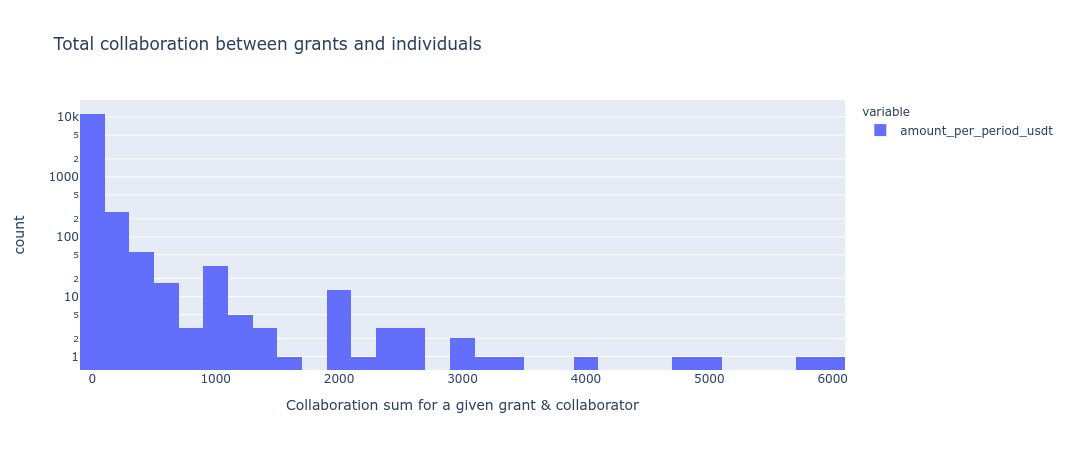

time: 959 ms


In [7]:
(grouped_data.amount_per_period_usdt
             .sum()
             .hist(log_y=True,
                   nbins=50,
                   title='Total collaboration between grants and individuals',
                   labels={'value': 'Collaboration sum for a given grant & collaborator'}))

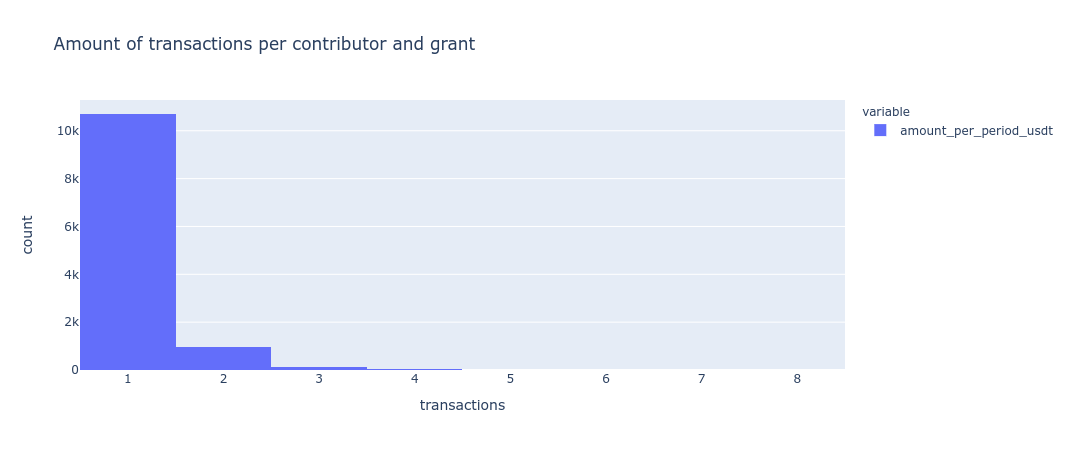

time: 244 ms


In [8]:
(grouped_data.amount_per_period_usdt
             .count()
             .hist(title='Amount of transactions per contributor and grant',
                   labels={'value': 'transactions'}))

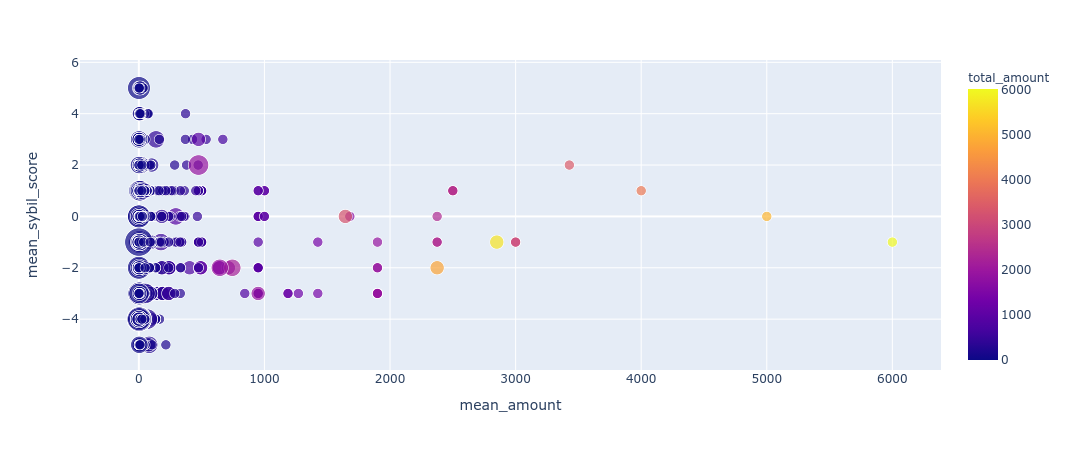

time: 2.24 s


In [9]:
y_1 = grouped_data.sybil_score.mean().rename('mean_sybil_score')
y_2 = grouped_data.amount_per_period_usdt.sum().rename('total_amount')
y_3 = grouped_data.amount_per_period_usdt.count().rename('tx_count')
y_4 = grouped_data.amount_per_period_usdt.mean().rename('mean_amount')

fig_df = pd.DataFrame([y_1, y_2, y_3, y_4]).T
px.scatter(fig_df,
           x='mean_amount',
           y='mean_sybil_score',
           color='total_amount',
           size='tx_count')

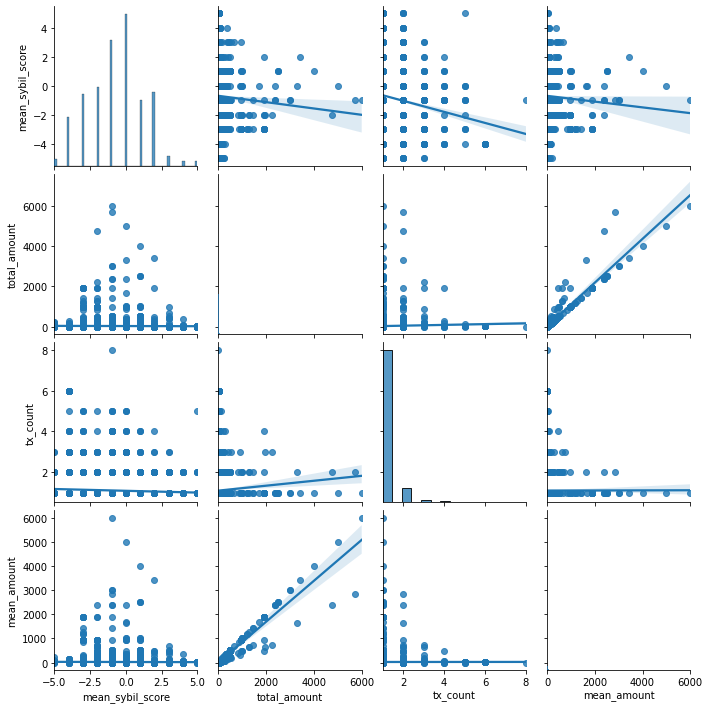

time: 1min 51s


In [10]:
sns.pairplot(fig_df, kind='reg')

### Graph structure overview

In [11]:
G = nx.from_pandas_edgelist(df,
                            source="profile_for_clr_id",
                            target="title",
                            edge_attr=True)

time: 1.75 s


Calculating best minimal value for power law fit
/home/danlessa/.anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning:

invalid value encountered in true_divide

/home/danlessa/.anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning:

invalid value encountered in true_divide



Text(0, 0.5, 'Probability Density')

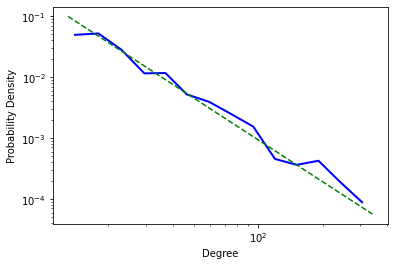

time: 3.12 s


In [12]:
degree_sequence = sorted(
    [d for n, d in G.degree() if d < 800],
    reverse=True)  # used for degree distribution and powerlaw test
fit = powerlaw.Fit(degree_sequence)

fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)
plt.xlabel("Degree")
plt.ylabel("Probability Density")

In [13]:
grant_sizes = (df.groupby('title')
                 .amount_per_period_usdt
                 .sum()
                 .map(lambda x: x / 20 + 1)
                 .to_dict())

collaborator_sizes = (df.groupby('profile_for_clr_id')
                        .amount_per_period_usdt
                        .sum()
                        .map(lambda x: x / 10 + 1)
                        .to_dict())

node_sizes = {**grant_sizes, **collaborator_sizes}
nx.set_node_attributes(G, node_sizes, 'size')

time: 55.9 ms


In [14]:
grant_color = (df.groupby('title')
                 .sybil_score
                 .mean()
                 .to_dict())

collaborator_color = (df.groupby('profile_for_clr_id')
                        .sybil_score
                        .mean()
                        .to_dict())

node_colors = {**grant_color, **collaborator_color}
nx.set_node_attributes(G, node_colors, 'color')

time: 63.7 ms


In [15]:
edge_weights = {n: v / 100 for n, v in nx.get_edge_attributes(G, 'amount_per_period_usdt').items()}

nx.set_edge_attributes(G, edge_weights, 'weight')

time: 162 ms


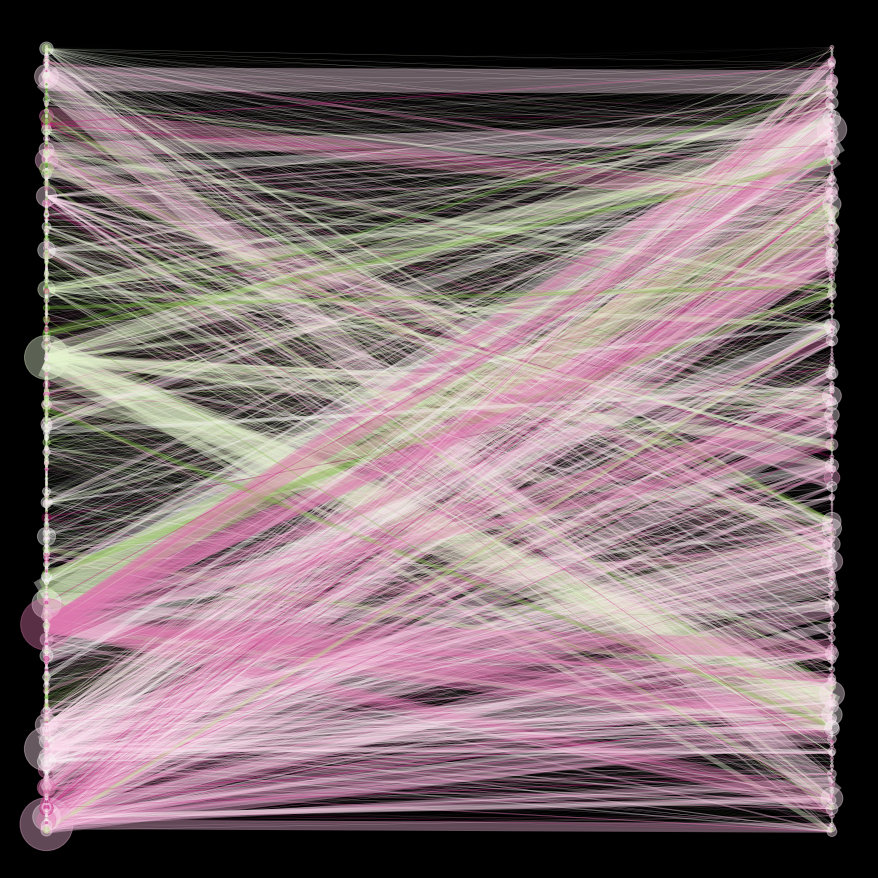

time: 18.2 s


In [17]:
# Thanks Z - https://github.com/thelastjosh/govbase/blob/master/airtableToNetworkx.ipynb

dt = len(PROFILES) / len(GRANTS)
profile_pos = {node: (0, i) for (i, node) in enumerate(PROFILES)}
grant_pos = {node: (1, i * dt) for (i, node) in enumerate(GRANTS)}
pos = {**profile_pos, **grant_pos}
labels = {node: node for node in PROFILES | GRANTS}


options = {
    "node_color": list(nx.get_node_attributes(G, 'color').values()),
    "node_size": list(nx.get_node_attributes(G, 'size').values()),
    "edge_color": nx.get_edge_attributes(G, 'sybil_score').values(),
    "width": list(nx.get_edge_attributes(G, 'weight').values()),
    "alpha": 0.4,
    "cmap": plt.cm.PiYG,
    "edge_cmap": plt.cm.PiYG,
    "with_labels": False,
}

fig = plt.figure(figsize=(12, 12))
nx.draw(G, pos, **options)
fig.set_facecolor('black')
plt.show()